# Classification with Decision Trees and Random Forests

In [1]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn import tree
from sklearn.ensemble import RandomForestClassifier
from classification_utils import *
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import RandomizedSearchCV
from sklearn.model_selection import cross_validate
from sklearn.datasets import make_blobs
import statistics
from sklearn.metrics import ConfusionMatrixDisplay, confusion_matrix
from sklearn.decomposition import PCA
import pickle
from sklearn.metrics import RocCurveDisplay
from sklearn import tree

The only preprocessing step applyed is the one-hot-encoding of the **Lang** feature

## Decision trees

Run grid search - cross validation over the Decision Tree sklearn implementation, the parameters over which the grid search will run are:
- **ccp_alpha**: Complexity parameter used for Minimal Cost-Complexity Pruning.
- **min_weight_fraction_leaf**: The minimum weighted fraction of the sum total of weights (of all the input samples) required to be at a leaf node.
- **min_sample_split**: The minimum number of samples required to split an internal node.
- **min_sample_leaf**: The minimum number of samples required to be at a leaf node.
- **criterion**: The function to measure the quality of a split.

In [2]:
data = pd.read_csv("../dataset/cleaned_user_profiles.csv", index_col=0)
data = data.join(pd.get_dummies(data["lang"]))
train_set, test_set, train_label, test_label = prepare_data(data)

Classification features : ['created_at', 'statuses_count', 'avg_length', 'avg_special_chars', 'urls_ratio', 'mentions_ratio', 'hashtags_ratio', 'reply_count_mean', 'reply_count_std', 'favorite_count_mean', 'favorite_count_std', 'favorite_count_entropy', 'retweet_count_mean', 'retweet_count_std', 'retweet_count_entropy', 'ar', 'da', 'de', 'el', 'en', 'es', 'fil', 'fr', 'id', 'it', 'ja', 'ko', 'nl', 'pl', 'pt', 'ru', 'sv', 'tr', 'zh']


In [3]:
param_grid = {
              'ccp_alpha': [0.0, 0.1, 0.05, 0.01, 0.005, 0.001, 0.0005, 0.0001, 0.5, 0.2],
              'min_weight_fraction_leaf': [0.0, 0.1, 0.05, 0.01, 0.005, 0.001, 0.0005, 0.0001, 0.5, 0.2],
              'min_samples_split': [2, 3, 4],
              'min_samples_leaf': [1, 2, 3, 4],
              'criterion': ['gini', 'entropy']
             }


dt = tree.DecisionTreeClassifier()

grid = GridSearchCV(
    dt,
    param_grid,
    cv=3,
    scoring='accuracy',
    return_train_score=False,
    n_jobs=-1,
    verbose=1
)


grid.fit(train_set.values, train_label)
print(
    "The best parameters are %s with a score of %0.5f"
    % (grid.best_params_, grid.best_score_)
)


Fitting 3 folds for each of 2400 candidates, totalling 7200 fits
The best parameters are {'ccp_alpha': 0.001, 'criterion': 'gini', 'min_samples_leaf': 1, 'min_samples_split': 2, 'min_weight_fraction_leaf': 0.0} with a score of 0.89894


In [4]:
dt = grid.best_estimator_
dt

DecisionTreeClassifier(ccp_alpha=0.001)

[Text(0.5, 0.9375, 'X[1] <= 122.5\ngini = 0.498\nsamples = 8055\nvalue = [3774, 4281]'),
 Text(0.4444444444444444, 0.8125, 'X[1] <= 24.5\ngini = 0.336\nsamples = 5444\nvalue = [1163, 4281]'),
 Text(0.3888888888888889, 0.6875, 'gini = 0.0\nsamples = 306\nvalue = [306, 0]'),
 Text(0.5, 0.6875, 'X[5] <= 0.235\ngini = 0.278\nsamples = 5138\nvalue = [857, 4281]'),
 Text(0.2222222222222222, 0.5625, 'X[1] <= 52.5\ngini = 0.142\nsamples = 2610\nvalue = [201, 2409]'),
 Text(0.1111111111111111, 0.4375, 'X[24] <= 0.5\ngini = 0.329\nsamples = 688\nvalue = [143, 545]'),
 Text(0.05555555555555555, 0.3125, 'gini = 0.361\nsamples = 604\nvalue = [143, 461]'),
 Text(0.16666666666666666, 0.3125, 'gini = 0.0\nsamples = 84\nvalue = [0, 84]'),
 Text(0.3333333333333333, 0.4375, 'X[1] <= 53.5\ngini = 0.059\nsamples = 1922\nvalue = [58, 1864]'),
 Text(0.2777777777777778, 0.3125, 'gini = 0.0\nsamples = 1497\nvalue = [0, 1497]'),
 Text(0.3888888888888889, 0.3125, 'X[24] <= 0.5\ngini = 0.236\nsamples = 425\nvalue

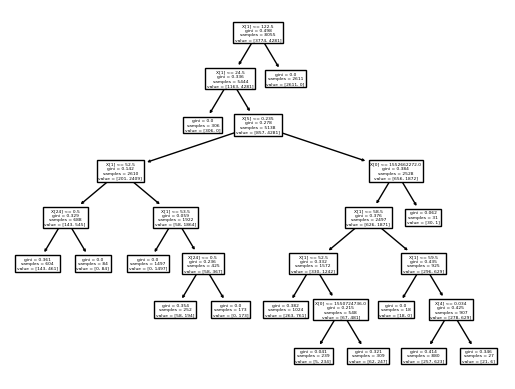

In [5]:
tree.plot_tree(dt)

## Print Metrics

In [6]:
train_pred = dt.predict(train_set.values)
test_pred = dt.predict(test_set.values)

In [7]:
print_metrics(train_label, train_pred, test_label, test_pred)

Accuracy train set  0.9013035381750466
Accuracy test set  0.8960324355632783
Precision train set  0.9161702590948504
Recall train set  0.9013035381750466
F1 score train set  0.899733226153419
Support train set  (array([0.99766121, 0.8443303 ]), array([0.79120297, 0.99836487]), array([0.8825181 , 0.91490956]), array([3774, 4281], dtype=int64))


In [8]:
report_scores(test_label, test_pred)

              precision    recall  f1-score   support

        <=50       0.99      0.79      0.88      1618
         >50       0.84      0.99      0.91      1835

    accuracy                           0.90      3453
   macro avg       0.92      0.89      0.89      3453
weighted avg       0.91      0.90      0.89      3453



### Confusion Matrix

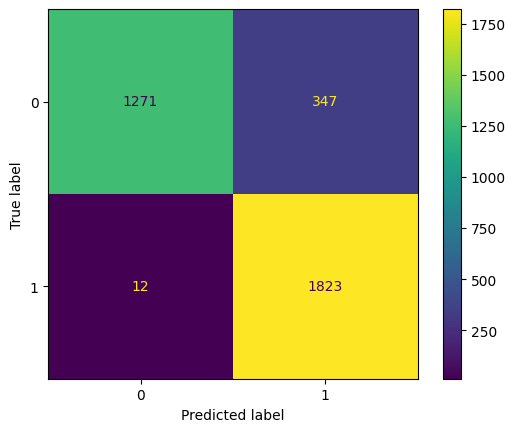

In [9]:
predictions = dt.predict(test_set.values)

cm = confusion_matrix(test_label, predictions)
disp = ConfusionMatrixDisplay(confusion_matrix = cm)
disp.plot()
plt.show()

### ROC-Curve

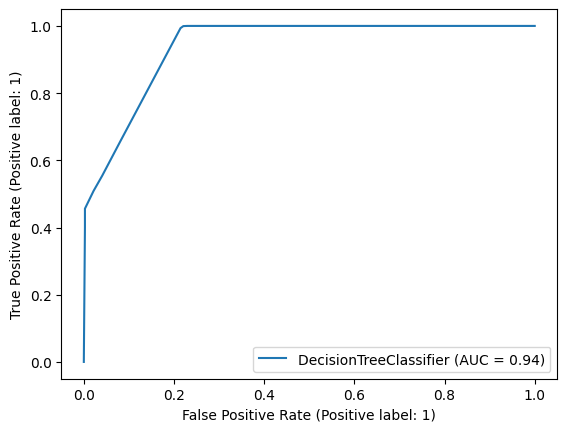

In [10]:
RocCurveDisplay.from_estimator(dt, test_set.values, test_label)
plt.show()

### PCA blobs

In [11]:
pca = PCA(n_components=2)
test_set_reduced = pca.fit_transform(test_set.values)

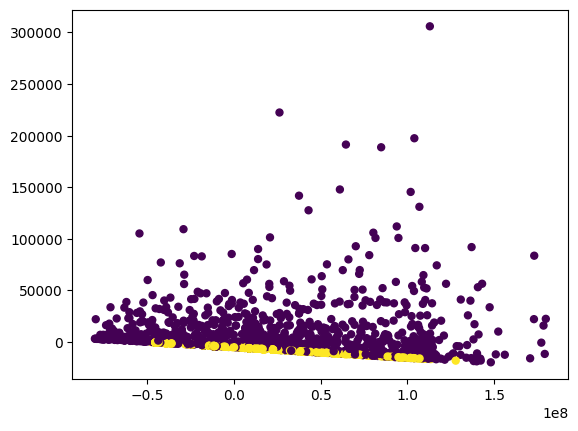

In [12]:
#true labels
plt.scatter(test_set_reduced[:, 0], test_set_reduced[:, 1], c=test_label, s=25);

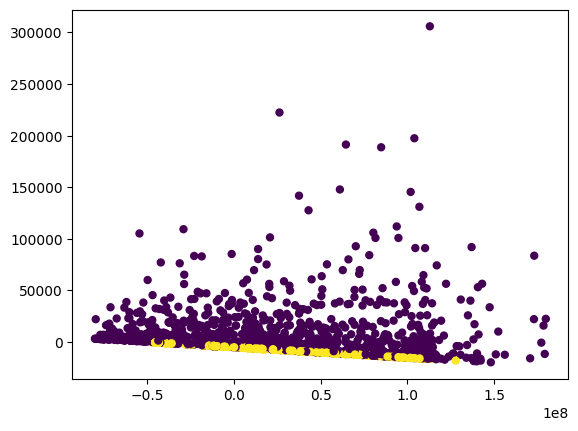

In [13]:
#predicted labels
plt.scatter(test_set_reduced[:, 0], test_set_reduced[:, 1], c=test_pred, s=25);

### Save model

In [14]:
with open("../models_checkpoints/decision_tree_lang.bin", "wb") as f:
    pickle.dump(dt, f)

### Removed "lang" attribute for classification

Since we are not sure in the usage of Lang feature, we will try to remove that feature to see the difference in the accuracy, we have tryed to remove other features, but in those cases the model drop something in accuracy, we will see that for Lang this is not true.

In [15]:
data = pd.read_csv("../dataset/cleaned_user_profiles.csv", index_col=0)
data.drop(columns=['lang'])
train_set, test_set, train_label, test_label = prepare_data(data)

Classification features : ['created_at', 'statuses_count', 'avg_length', 'avg_special_chars', 'urls_ratio', 'mentions_ratio', 'hashtags_ratio', 'reply_count_mean', 'reply_count_std', 'favorite_count_mean', 'favorite_count_std', 'favorite_count_entropy', 'retweet_count_mean', 'retweet_count_std', 'retweet_count_entropy']


In [16]:
param_grid = {
              'ccp_alpha': [0.0, 0.1, 0.05, 0.01, 0.005, 0.001, 0.0005, 0.0001, 0.5, 0.2],
              'min_weight_fraction_leaf': [0.0, 0.1, 0.05, 0.01, 0.005, 0.001, 0.0005, 0.0001, 0.5, 0.2],
              'min_samples_split': [2, 3, 4],
              'min_samples_leaf': [1, 2, 3, 4],
              'criterion': ['gini', 'entropy']
             }


dt = tree.DecisionTreeClassifier()

grid = GridSearchCV(
    dt,
    param_grid,
    cv=3,
    scoring='accuracy',
    return_train_score=False,
    verbose=1,
    n_jobs=-1
)


grid.fit(train_set.values, train_label)
print(
    "The best parameters are %s with a score of %0.5f"
    % (grid.best_params_, grid.best_score_)
)


Fitting 3 folds for each of 2400 candidates, totalling 7200 fits
The best parameters are {'ccp_alpha': 0.001, 'criterion': 'gini', 'min_samples_leaf': 1, 'min_samples_split': 2, 'min_weight_fraction_leaf': 0.0} with a score of 0.89894


In [17]:
dt = grid.best_estimator_
dt

DecisionTreeClassifier(ccp_alpha=0.001)

[Text(0.43333333333333335, 0.9375, 'X[1] <= 122.5\ngini = 0.498\nsamples = 8055\nvalue = [3774, 4281]'),
 Text(0.36666666666666664, 0.8125, 'X[1] <= 24.5\ngini = 0.336\nsamples = 5444\nvalue = [1163, 4281]'),
 Text(0.3, 0.6875, 'gini = 0.0\nsamples = 306\nvalue = [306, 0]'),
 Text(0.43333333333333335, 0.6875, 'X[5] <= 0.235\ngini = 0.278\nsamples = 5138\nvalue = [857, 4281]'),
 Text(0.13333333333333333, 0.5625, 'X[1] <= 52.5\ngini = 0.142\nsamples = 2610\nvalue = [201, 2409]'),
 Text(0.06666666666666667, 0.4375, 'gini = 0.329\nsamples = 688\nvalue = [143, 545]'),
 Text(0.2, 0.4375, 'X[1] <= 53.5\ngini = 0.059\nsamples = 1922\nvalue = [58, 1864]'),
 Text(0.13333333333333333, 0.3125, 'gini = 0.0\nsamples = 1497\nvalue = [0, 1497]'),
 Text(0.26666666666666666, 0.3125, 'X[2] <= 72.046\ngini = 0.236\nsamples = 425\nvalue = [58, 367]'),
 Text(0.2, 0.1875, 'gini = 0.356\nsamples = 237\nvalue = [55, 182]'),
 Text(0.3333333333333333, 0.1875, 'gini = 0.031\nsamples = 188\nvalue = [3, 185]'),
 Te

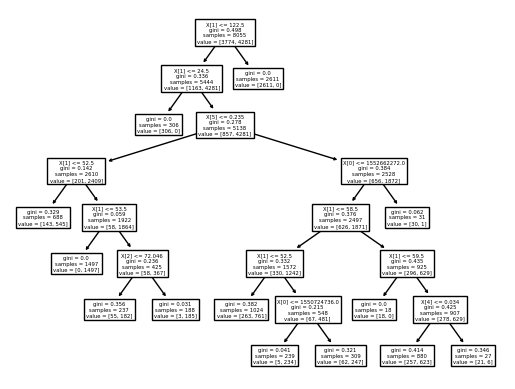

In [18]:
tree.plot_tree(dt)

## Print Metrics

In [19]:
train_pred = dt.predict(train_set.values)
test_pred = dt.predict(test_set.values)

In [20]:
print_metrics(train_label, train_pred, test_label, test_pred)

Accuracy train set  0.9013035381750466
Accuracy test set  0.8960324355632783
Precision train set  0.9161702590948504
Recall train set  0.9013035381750466
F1 score train set  0.899733226153419
Support train set  (array([0.99766121, 0.8443303 ]), array([0.79120297, 0.99836487]), array([0.8825181 , 0.91490956]), array([3774, 4281], dtype=int64))


In [21]:
report_scores(test_label,test_pred)

              precision    recall  f1-score   support

        <=50       0.99      0.79      0.88      1618
         >50       0.84      0.99      0.91      1835

    accuracy                           0.90      3453
   macro avg       0.92      0.89      0.89      3453
weighted avg       0.91      0.90      0.89      3453



### Confusion Matrix

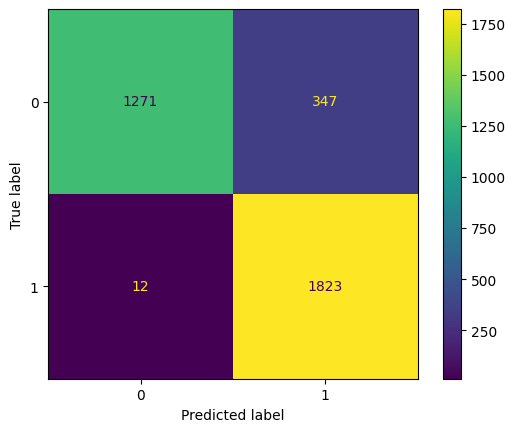

In [22]:
predictions = dt.predict(test_set.values)

cm = confusion_matrix(test_label, predictions)
disp = ConfusionMatrixDisplay(confusion_matrix = cm)
disp.plot()
plt.show()

### ROC-Curve

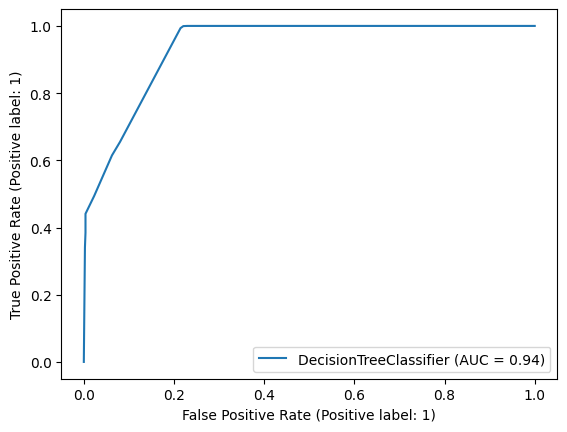

In [23]:
RocCurveDisplay.from_estimator(dt, test_set.values, test_label)
plt.show()

### PCA Blobs

In [24]:
pca = PCA(n_components=2)
test_set_reduced = pca.fit_transform(test_set.values)

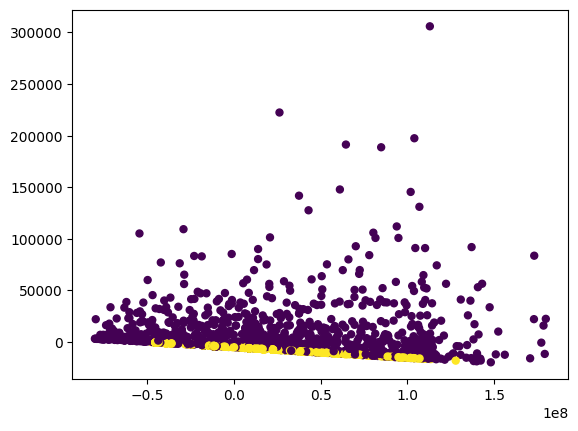

In [25]:
#true labels
plt.scatter(test_set_reduced[:, 0], test_set_reduced[:, 1], c=test_label, s=25);

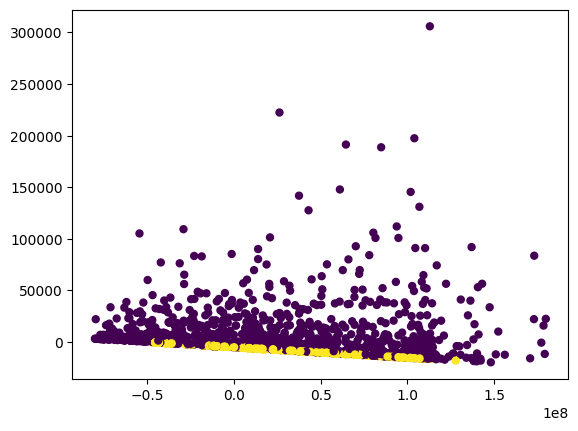

In [26]:
#predicted labels
plt.scatter(test_set_reduced[:, 0], test_set_reduced[:, 1], c=test_pred, s=25);

### Save model

In [27]:
with open("../models_checkpoints/decision_tree_no_lang.bin", "wb") as f:
    pickle.dump(dt, f)

## Random forest

A random forest is a meta estimator that fits a number of decision tree classifiers on various sub-samples of the dataset and uses averaging to improve the predictive accuracy and control over-fitting.

Run grid search - cross validation over the RandomForestClassifier sklearn implementation, the parameters over which the grid search will run are:
- **ccp_alpha**: Complexity parameter used for Minimal Cost-Complexity Pruning.
- **min_weight_fraction_leaf**: The minimum weighted fraction of the sum total of weights (of all the input samples) required to be at a leaf node.
- **min_sample_split**: The minimum number of samples required to split an internal node.
- **min_sample_leaf**: The minimum number of samples required to be at a leaf node.
- **n_estimators**: The number of trees in the forest.

In [28]:
data = pd.read_csv("../dataset/cleaned_user_profiles.csv", index_col=0)
data = data.join(pd.get_dummies(data["lang"]))
train_set, test_set, train_label, test_label = prepare_data(data)

Classification features : ['created_at', 'statuses_count', 'avg_length', 'avg_special_chars', 'urls_ratio', 'mentions_ratio', 'hashtags_ratio', 'reply_count_mean', 'reply_count_std', 'favorite_count_mean', 'favorite_count_std', 'favorite_count_entropy', 'retweet_count_mean', 'retweet_count_std', 'retweet_count_entropy', 'ar', 'da', 'de', 'el', 'en', 'es', 'fil', 'fr', 'id', 'it', 'ja', 'ko', 'nl', 'pl', 'pt', 'ru', 'sv', 'tr', 'zh']


In [29]:
param_grid = {
    'min_samples_leaf': [1, 2, 3],
    'min_samples_split': [2, 3, 4],
    'ccp_alpha': [0.0, 0.1, 0.05, 0.001],
    'min_weight_fraction_leaf': [0.0, 0.1, 0.05, 0.001],
    'n_estimators': np.arange(80, 150, 10),
}

rf = RandomForestClassifier()

grid = GridSearchCV(
    rf,
    param_grid,
    cv=3,
    scoring='accuracy',
    return_train_score=False,
    verbose=1,
    n_jobs=-1
)

grid.fit(train_set.values, train_label)

Fitting 3 folds for each of 1008 candidates, totalling 3024 fits


GridSearchCV(cv=3, estimator=RandomForestClassifier(), n_jobs=-1,
             param_grid={'ccp_alpha': [0.0, 0.1, 0.05, 0.001],
                         'min_samples_leaf': [1, 2, 3],
                         'min_samples_split': [2, 3, 4],
                         'min_weight_fraction_leaf': [0.0, 0.1, 0.05, 0.001],
                         'n_estimators': array([ 80,  90, 100, 110, 120, 130, 140])},
             scoring='accuracy', verbose=1)

In [30]:
rf = grid.best_estimator_
rf

RandomForestClassifier(min_samples_leaf=2, min_weight_fraction_leaf=0.001,
                       n_estimators=140)

## Print Metrics

In [31]:
train_pred = rf.predict(train_set.values)
test_pred = rf.predict(test_set.values)

In [32]:
print_metrics(train_label, train_pred, test_label, test_pred)

Accuracy train set  0.9047796399751707
Accuracy test set  0.8960324355632783
Precision train set  0.9188382455788503
Recall train set  0.9047796399751707
F1 score train set  0.9033399475142367
Support train set  (array([0.99834272, 0.8487495 ]), array([0.79809221, 0.99883205]), array([0.8870564 , 0.91769503]), array([3774, 4281], dtype=int64))


### Confusion Matrix

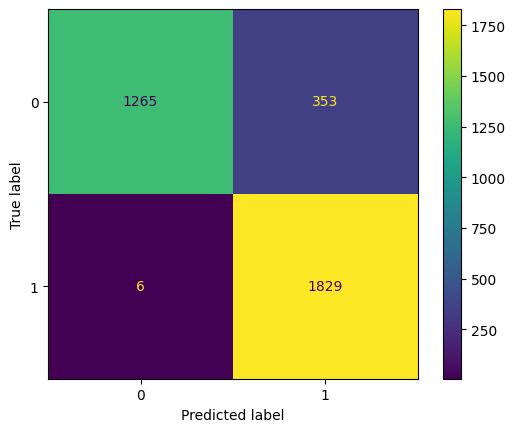

In [33]:
predictions = rf.predict(test_set.values)

cm = confusion_matrix(test_label, predictions)
disp = ConfusionMatrixDisplay(confusion_matrix = cm)
disp.plot()
plt.show()

### ROC-Curve

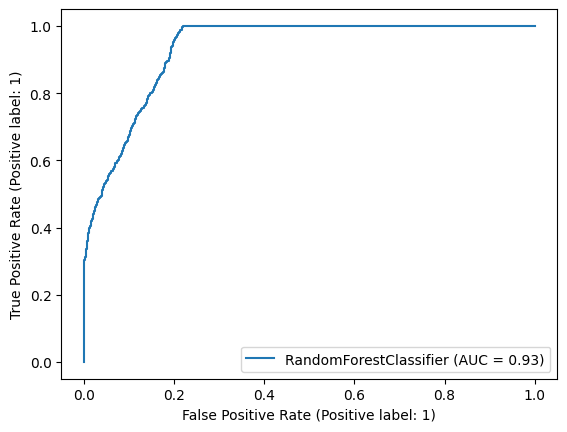

In [34]:
RocCurveDisplay.from_estimator(rf, test_set.values, test_label)
plt.show()

### PCA Blobs

In [35]:
pca = PCA(n_components=2)
test_set_reduced = pca.fit_transform(test_set.values)

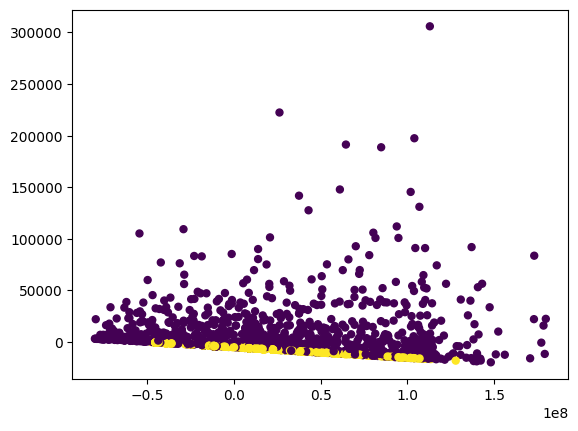

In [36]:
#true labels
plt.scatter(test_set_reduced[:, 0], test_set_reduced[:, 1], c=test_label, s=25);

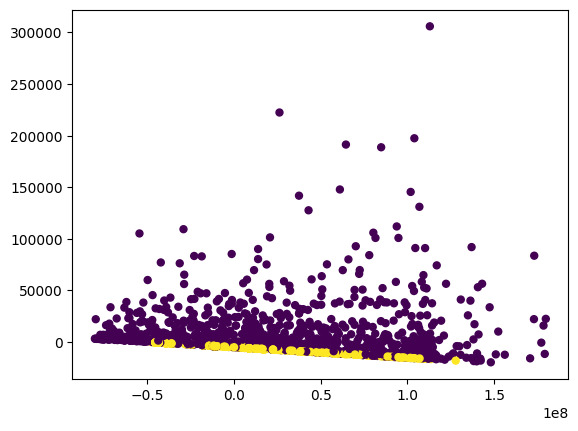

In [37]:
#predicted labels
plt.scatter(test_set_reduced[:, 0], test_set_reduced[:, 1], c=test_pred, s=25);

### Save model

In [38]:
with open("../models_checkpoints/random_forest_lang.bin", "wb") as f:
    pickle.dump(rf, f)

### Removed "lang" attribute for classification

In [39]:
data = pd.read_csv("../dataset/cleaned_user_profiles.csv", index_col=0)
train_set, test_set, train_label, test_label = prepare_data(data)

Classification features : ['created_at', 'statuses_count', 'avg_length', 'avg_special_chars', 'urls_ratio', 'mentions_ratio', 'hashtags_ratio', 'reply_count_mean', 'reply_count_std', 'favorite_count_mean', 'favorite_count_std', 'favorite_count_entropy', 'retweet_count_mean', 'retweet_count_std', 'retweet_count_entropy']


In [40]:
param_grid = {
    'min_samples_leaf': [1, 2, 3],
    'min_samples_split': [2, 3, 4],
    'ccp_alpha': [0.0, 0.1, 0.05, 0.001],
    'min_weight_fraction_leaf': [0.0, 0.1, 0.05, 0.001],
    'n_estimators': np.arange(80, 150, 10),
}

rf = RandomForestClassifier()

grid = GridSearchCV(
    rf,
    param_grid,
    cv=3,
    scoring='accuracy',
    return_train_score=False,
    verbose=1,
    n_jobs=-1
)

grid.fit(train_set.values, train_label)

Fitting 3 folds for each of 1008 candidates, totalling 3024 fits


GridSearchCV(cv=3, estimator=RandomForestClassifier(), n_jobs=-1,
             param_grid={'ccp_alpha': [0.0, 0.1, 0.05, 0.001],
                         'min_samples_leaf': [1, 2, 3],
                         'min_samples_split': [2, 3, 4],
                         'min_weight_fraction_leaf': [0.0, 0.1, 0.05, 0.001],
                         'n_estimators': array([ 80,  90, 100, 110, 120, 130, 140])},
             scoring='accuracy', verbose=1)

In [41]:
rf = grid.best_estimator_
rf

RandomForestClassifier(ccp_alpha=0.001, min_samples_leaf=3, min_samples_split=4,
                       min_weight_fraction_leaf=0.001, n_estimators=120)

## Print Metrics

In [42]:
train_pred = rf.predict(train_set.values)
test_pred = rf.predict(test_set.values)

In [43]:
print_metrics(train_label, train_pred, test_label, test_pred)

Accuracy train set  0.9001862197392924
Accuracy test set  0.894874022589053
Precision train set  0.9151184863031224
Recall train set  0.9001862197392924
F1 score train set  0.8985881216460494
Support train set  (array([0.99665552, 0.84323791]), array([0.78961314, 0.9976641 ]), array([0.88113542, 0.91397389]), array([3774, 4281], dtype=int64))


### Confusion Matrix

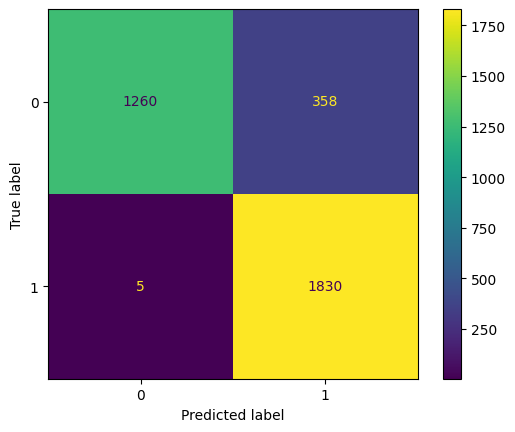

In [44]:
predictions = rf.predict(test_set.values)

cm = confusion_matrix(test_label, predictions)
disp = ConfusionMatrixDisplay(confusion_matrix = cm)
disp.plot()
plt.show()

### ROC-Curve

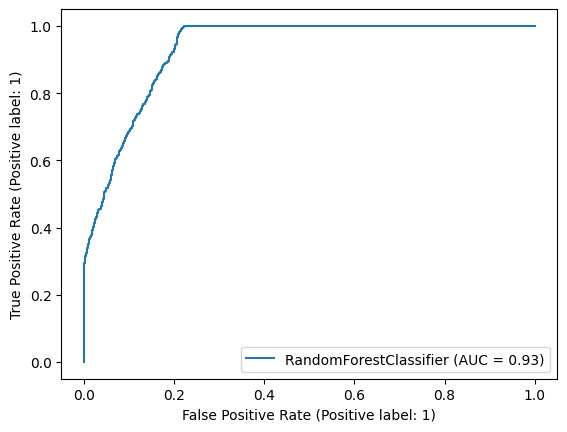

In [45]:
RocCurveDisplay.from_estimator(rf, test_set.values, test_label)
plt.show()

### PCA Blobs

In [46]:
pca = PCA(n_components=2)
test_set_reduced = pca.fit_transform(test_set.values)

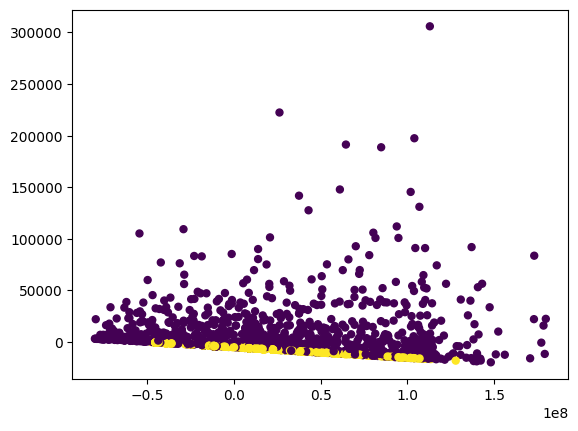

In [47]:
#true labels
plt.scatter(test_set_reduced[:, 0], test_set_reduced[:, 1], c=test_label, s=25);

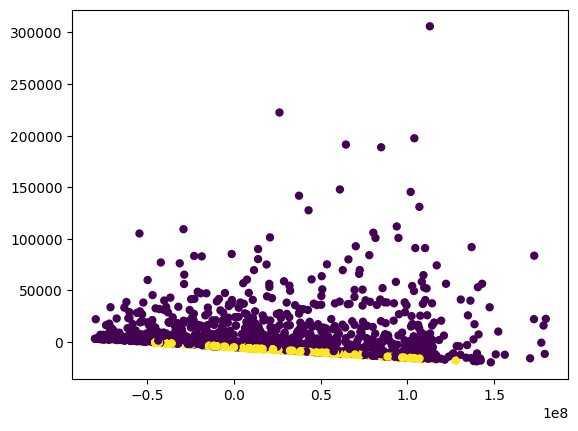

In [48]:
#predicted labels
plt.scatter(test_set_reduced[:, 0], test_set_reduced[:, 1], c=test_pred, s=25);

### Save model

In [49]:
with open("../models_checkpoints/random_forest_no_lang.bin", "wb") as f:
    pickle.dump(rf, f)

## Random Hyperparameter Grid Search

Try the RandomizedSearchCV from Sklearn, over the dataset without the **Lang** feature.

In contrast to GridSearchCV, not all parameter values are tried out, but rather a fixed number of parameter settings is sampled from the specified distributions

In [50]:
n_estimators = [int(x) for x in np.linspace(start = 200, stop = 2000, num = 10)]
max_features = ['auto', 'sqrt']
max_depth = [int(x) for x in np.linspace(10, 110, num = 11)]
max_depth.append(None)
min_samples_split = [2, 5, 10]
min_samples_leaf = [1, 2, 4]
bootstrap = [True, False]

random_grid = {'n_estimators': n_estimators,
               'max_features': max_features,
               'max_depth': max_depth,
               'min_samples_split': min_samples_split,
               'min_samples_leaf': min_samples_leaf,
               'bootstrap': bootstrap}

rf = RandomForestClassifier()

rf_random = RandomizedSearchCV(
    estimator = rf,
    param_distributions = random_grid,
    n_iter = 100,
    cv = 3,
    verbose=1,
    random_state=42,
    n_jobs = -1
)

rf_random.fit(train_set.values, train_label)
print(
    "The best parameters are %s with a score of %0.5f"
    % (rf_random.best_params_, rf_random.best_score_)
)

Fitting 3 folds for each of 100 candidates, totalling 300 fits
The best parameters are {'n_estimators': 2000, 'min_samples_split': 10, 'min_samples_leaf': 1, 'max_features': 'sqrt', 'max_depth': 10, 'bootstrap': False} with a score of 0.89870


In [51]:
rf = rf_random.best_estimator_

## Print Metrics

In [52]:
train_pred = rf.predict(train_set.values)
test_pred = rf.predict(test_set.values)

In [53]:
print_metrics(train_label, train_pred, test_label, test_pred)

Accuracy train set  0.9073867163252638
Accuracy test set  0.8954532290761656
Precision train set  0.9211304023450276
Recall train set  0.9073867163252638
F1 score train set  0.9060193962854863
Support train set  (array([1.        , 0.85160135]), array([0.80233174, 1.        ]), array([0.89032637, 0.91985389]), array([3774, 4281], dtype=int64))


### Confusion Matrix

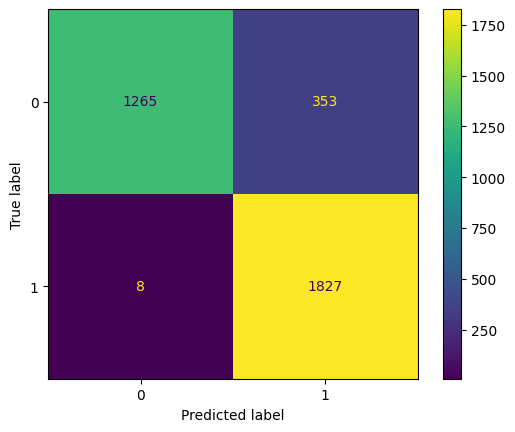

In [54]:
predictions = rf.predict(test_set.values)

cm = confusion_matrix(test_label, predictions)
disp = ConfusionMatrixDisplay(confusion_matrix = cm)
disp.plot()
plt.show()

### ROC-Curve

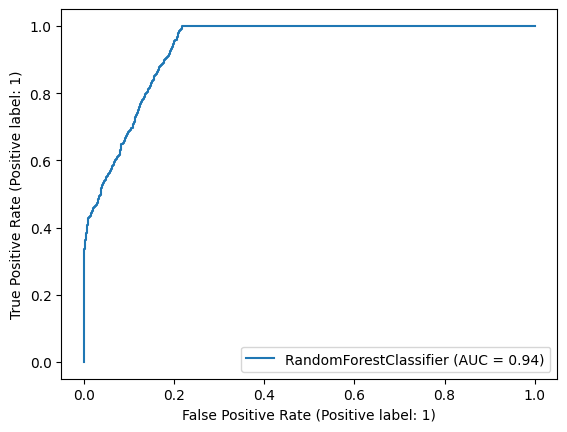

In [55]:
RocCurveDisplay.from_estimator(rf, test_set.values, test_label)
plt.show()

### PCA Blobs

In [56]:
pca = PCA(n_components=2)
test_set_reduced = pca.fit_transform(test_set.values)

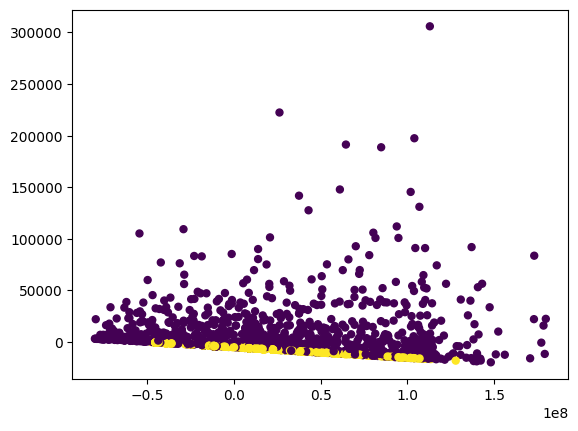

In [57]:
#true labels
plt.scatter(test_set_reduced[:, 0], test_set_reduced[:, 1], c=test_label, s=25);

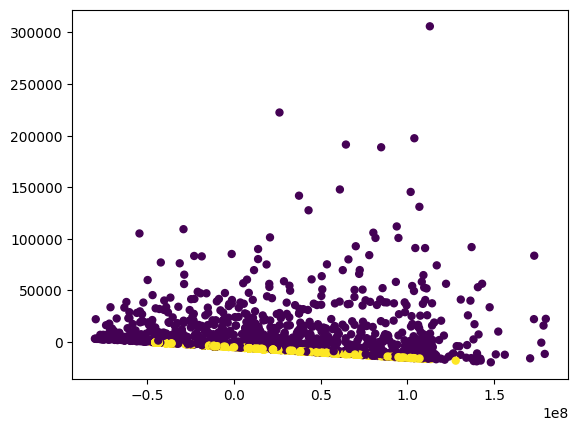

In [58]:
#predicted labels
plt.scatter(test_set_reduced[:, 0], test_set_reduced[:, 1], c=test_pred, s=25);

### Save Model

In [59]:
with open("../models_checkpoints/random_forest_2_no_lang.bin", "wb") as f:
    pickle.dump(rf, f)